# We would like to know what parameter variations still create a SFRD that is consistent with observations



In [10]:

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import WMAP9 as cosmo# Planck18 Planck 2018
from astropy.cosmology import z_at_value

from astropy.table import Table
import os
import paths

import matplotlib
from pylab import *
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec

def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   
# base_dir    = '/Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution/'
TNGlocation = str(paths.data) +'/'#'/Users/lieke/surfdrive/Documents/CompareCOMPAS/'
Martyna_data_dir = str(paths.data) +'/SFRD_Z_z_data/'
# '/Users/lieke/surfdrive/Documents/SFRD_fit/src/data/SFRD_Z_z_data/'


############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import importlib
importlib.reload(Z_SFRD)

############################
##PLOT setttings
from matplotlib import rc
import matplotlib
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# plt.rc('font', family='serif')
# rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))





In [2]:

Martyna_data_dir = str(paths.data) + '/SFRD_Z_z_data/'

labelsize=21
ticklabsize=17

def solar_metallicity_scales():
    Asplund09=[0.0134,8.69]
    AndersGrevesse89=[0.017,8.83]
    GrevesseSauval98=[0.0201,8.93]
    Villante14=[0.019,8.85]
    scale_ref=np.array(['Asplund09','AndersGrevesse89','GrevesseSauval98','Villante14'])
    Z_FOH_solar=np.array([Asplund09,AndersGrevesse89,GrevesseSauval98,Villante14])
    return scale_ref, Z_FOH_solar


##########################
def FOH2ZZ(foh,solar_Z_scale='AndersGrevesse89'):
    '''convert from 12+log[O/H] to ZZ'''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]    
    logZ = np.log10(Zsun) + foh - FOHsun
    ZZ=10**logZ
    return ZZ

#########################
#(array) oxygen to hydrogen abundance ratio ( FOH == 12 + log(O/H) )
# as used in the calculations - do not change
FOH_min, FOH_max = 5.3, 9.7
FOH_arr = np.linspace( FOH_min,FOH_max, 200)
dFOH=FOH_arr[1]-FOH_arr[0]

def ZZ2FOH(zz,solar_Z_scale='AndersGrevesse89'):
    '''convert from ZZ to 12+log[O/H] '''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]
    foh = np.log10(zz)-np.log10(Zsun)+FOHsun
    return foh

def smooth(d, c=2):
    if c == 0:
        return d
    x = np.zeros(len(d))
    x[0] = (d[1]+d[0])/2
    x[-1] = (d[-1]+d[-2])/2
    x[1:-1] = (2*d[1:-1]+d[:-2]+d[2:])/4
    return smooth(x, c=c-1)


def get_plot_data(input_file,zmin=0.,zmax=4):
    #read time, redshift and timestep as used in the calculations
    #starts at the highest redshift (z=z_start=10) and goes to z=0
    time, redshift_global, delt = np.loadtxt(Martyna_data_dir+'Time_redshift_deltaT.dat',unpack=True) 
    #reading mass per unit (comoving) volume formed in each z (row) - FOH (column) bin
    data=np.loadtxt(input_file)
    image_data=np.array( [data[ii]/(1e6*delt[ii]) for ii in range(len(delt))] )#fill the array with SFRD(FOH,z)

    redshift=redshift_global
    #select the interesting redshift range
    if( zmax!=10 or zmin!=0 ):
        idx= np.where(np.abs(np.array(redshift)-zmax)==np.abs(np.array(redshift)-zmax).min())[0][0] 
        idx0= np.where(np.abs(np.array(redshift)-zmin)==np.abs(np.array(redshift)-zmin).min())[0][0] 
        image_data = image_data[idx:idx0]
        redshift=redshift_global[idx:idx0]
        delt=delt[idx:idx0]

    image_data/=dFOH
    return image_data, redshift, delt


In [3]:
#####################################
# TNG data
#####################################
with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins         = f["MetalBins"][:]
    TNG_Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr            = f["Sfr"][:]

print('np.shape(MetalBins)', np.shape(MetalBins), 'np.shape(TNG_Lookbacktimes)', np.shape(TNG_Lookbacktimes))
print('np.shape(BoxSfr)', np.shape(BoxSfr))
    
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774            # https://www.tng-project.org/data/downloads/TNG300-1/
Box_side = 75/littleh  #75000 *u.kpc /littleh 
TNG_cosmic_SFR = (BoxSfr/Box_side**3).T # Msun/yr/Mpc^3

TNG_center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
step_TNG_logZ   = np.diff(np.log10(MetalBins))[0]
print('step_TNG_logZ',step_TNG_logZ)

TNG_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in TNG_Lookbacktimes[:-1]] 
TNG_redshifts.insert(len(TNG_redshifts),0) # put redshift zero at the end 
TNG_redshifts = np.array(TNG_redshifts)




np.shape(MetalBins) (61,) np.shape(TNG_Lookbacktimes) (100,)
np.shape(BoxSfr) (100, 60)
step_TNG_logZ 0.16666666666666607


Comparing at redshift 0.0
min_diff_index 99 is TNG z  0.0
dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.012431757514846573,-0.1455245025072418,1.5070172367515422,0.05059184944631069,-2.9548476822158074,0.01571876953597459,4.383021762577844,2.3646479317896576,4.795317784588146


dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.024538776833222038,-0.043129303953387654,0.7078186569704108,0.05506601953901857,-3.435018689692795,0.0383797248401756,2.6900849318367626,2.834427800362012,5.5805239020278545


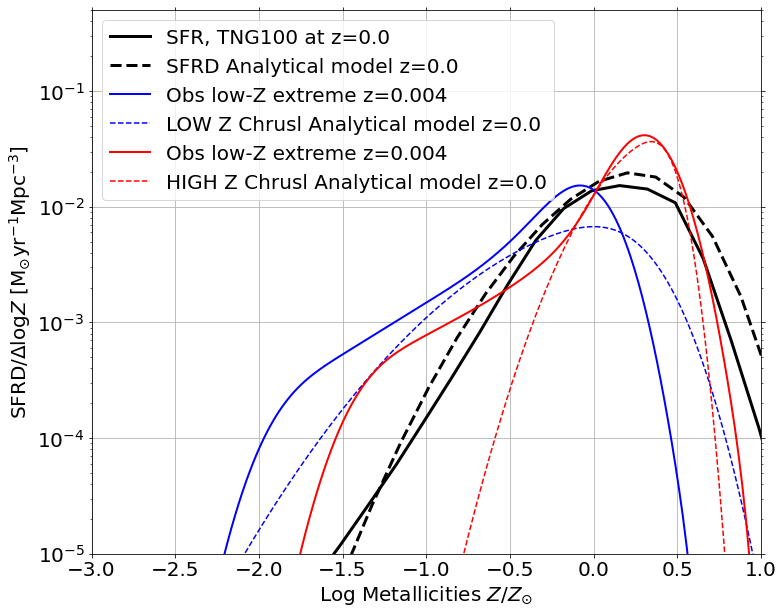

Comparing at redshift 0.5
min_diff_index 68 is TNG z  0.49324585025355533
dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.012431757514846573,-0.1455245025072418,1.5070172367515422,0.05059184944631069,-2.9548476822158074,0.01571876953597459,4.383021762577844,2.3646479317896576,4.795317784588146


dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.024538776833222038,-0.043129303953387654,0.7078186569704108,0.05506601953901857,-3.435018689692795,0.0383797248401756,2.6900849318367626,2.834427800362012,5.5805239020278545


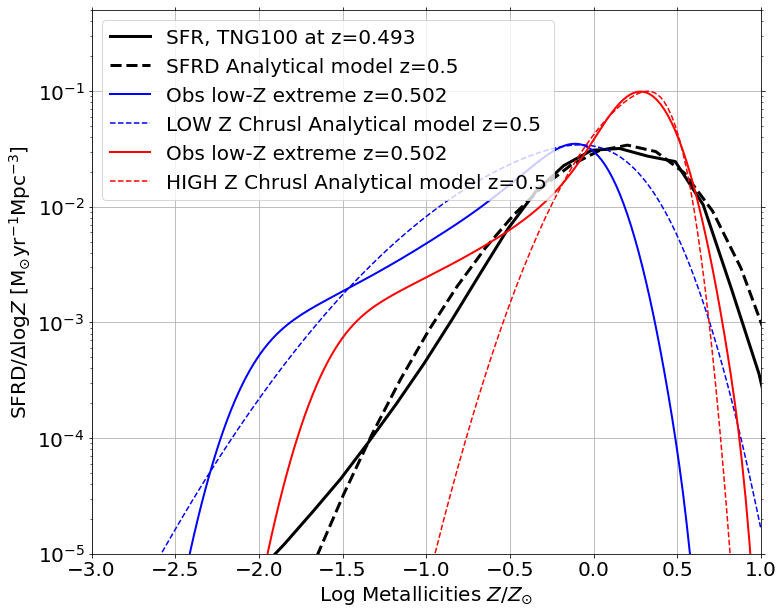

Comparing at redshift 3
min_diff_index 26 is TNG z  2.9782210279967
dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.012431757514846573,-0.1455245025072418,1.5070172367515422,0.05059184944631069,-2.9548476822158074,0.01571876953597459,4.383021762577844,2.3646479317896576,4.795317784588146


dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.024538776833222038,-0.043129303953387654,0.7078186569704108,0.05506601953901857,-3.435018689692795,0.0383797248401756,2.6900849318367626,2.834427800362012,5.5805239020278545


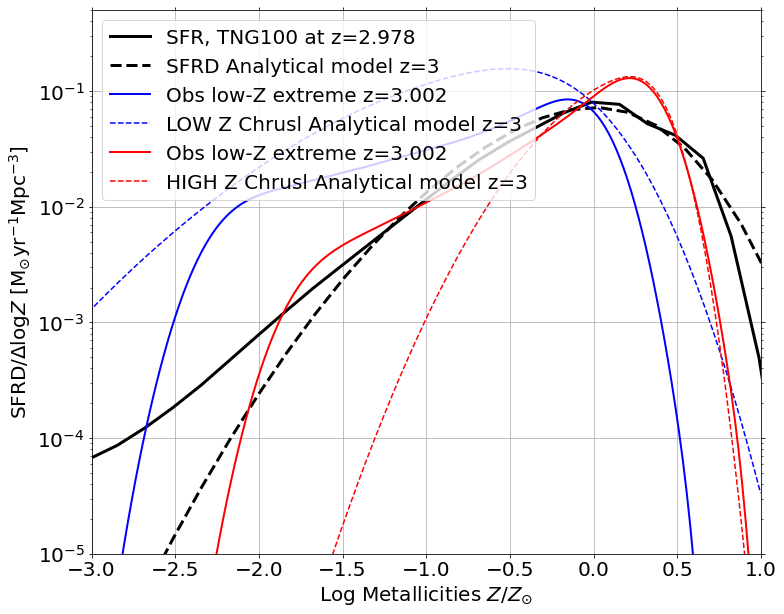

Comparing at redshift 6.0
min_diff_index 14 is TNG z  6.110336780676399
dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.012431757514846573,-0.1455245025072418,1.5070172367515422,0.05059184944631069,-2.9548476822158074,0.01571876953597459,4.383021762577844,2.3646479317896576,4.795317784588146


dFOH 0.022110552763819236 0.05091142919182978 0.022110552763819236


'params Martyna'

# mu0,muz,omega0,omegaz,alpha0,sf_a,sf_b,sf_c,sf_d
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.024538776833222038,-0.043129303953387654,0.7078186569704108,0.05506601953901857,-3.435018689692795,0.0383797248401756,2.6900849318367626,2.834427800362012,5.5805239020278545


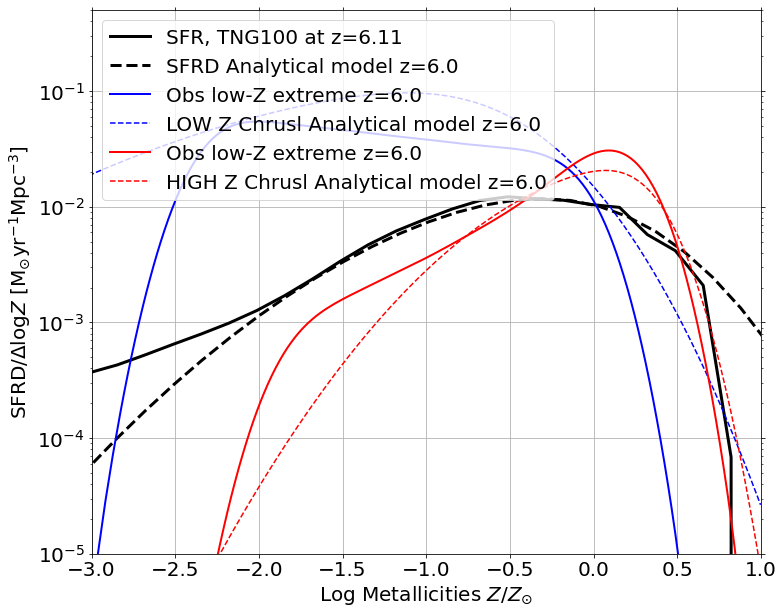

In [35]:
def get_SFRDzZ(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
               metal_params = [], SFR_Params = [], min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01): 
    mu_0, mu_z, omega_0, omega_z, alpha = metal_params
    a, b, c, d                          = SFR_Params
    # metallicity distribution
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                  omega_0=omega_0, omega_z =omega_z, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                  metals = metals ) #np.logspace(-5,1, num=1000)
    # SFR
    sfr        = Z_SFRD.Madau_Dickinson2014(redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
    # Combine it into a SFRD
    model_SFRD = (sfr*(dPdlogZ ).T ).value #step_logZ
    return model_SFRD, metallicities, step_logZ



#####################################
# 1D comparison of model and data
#####################################
def oneDcomparison(comparison_redshifts = [0.5], fit_param_filename = 'test_best_fit_parameters.txt', 
                  TNG_center_Zbin = TNG_center_Zbin, MetalBins = MetalBins,
                  colors = ['purple', 'lightblue', 'green', 'red']):
    
    #                    mu_0 = mu0_best, mu_z = muz_best, omega_0 = omega0_best, omega_z = omegaz_best, alpha = alpha0_best,
    #                    a = sf_a_best, b = sf_b_best, c = sf_c_best, d = sf_d_best):

    """
        mu_0, mu_z, omega_0, omega_z, alpha = metal_params
        a, b, c, d                          = SFR_Params
    """    
    Fid_SzZParams    =  Table.read(paths.data / fit_param_filename, format = 'csv')
    metals           = np.logspace(min(np.log10(MetalBins)), max(np.log10(MetalBins)), num = 60) 
    ZsunTNG = 0.0127

    #####################################
    for i, redshift in enumerate(comparison_redshifts):
        print('Comparing at redshift', redshift)
        
        ####################################
        # Variations on the SFRD
        metal_param_keys = ['# mu0']#,'muz','omega0','omegaz','alpha0']
        variations = [[0.015, 0.035],[-0.01, -0.25],[0.8, 1.4],[0.025, 0.1],[-0.9, -3.5] ]
        colors = ['purple' ,'#ff717b','navy',  '#00a6a0',  '#acbf00', '#ecb05b']
        for v, param_key in enumerate(metal_param_keys):
            
            #####################################
            # Actually start the plot!
            fig, ax = plt.subplots(figsize=(12,10))
        
            ####################################
            # Variations on the SFRD
            #####################################
            variation = Fid_SzZParams.copy()
            var = variations[v]
            for i in range(2): #Repeat for low and high value
                variation[param_key] = var[i]
                model_SFRD, metallicities, step_logZ = get_SFRDzZ(np.array([redshift]), metals = metals, 
                                               metal_params = variation['# mu0','muz','omega0','omegaz','alpha0'][0],
                                               SFR_Params = variation['sf_a','sf_b','sf_c','sf_d'][0])

#                 plt.plot(np.log10(metallicities/ZsunTNG), model_SFRD * step_logZ/np.diff(np.log10(metallicities))[0] , 
#                         label = 'var. model, %s = %s, z='%(param_key, var[i])+str(redshift), ls = '--',lw = 3, c = colors[v], zorder = 10)


            #####################################
            # TNG 100 data
            #####################################
            min_diff_index = np.argmin(abs(TNG_redshifts - redshift))
            print('min_diff_index', min_diff_index, 'is TNG z ', TNG_redshifts[min_diff_index])
            #step_TNG_logZ
            ax.plot(np.log10(TNG_center_Zbin/ZsunTNG), TNG_cosmic_SFR[:,min_diff_index] / step_TNG_logZ,
                   label = 'SFR, TNG100 at z='+str(np.round(TNG_redshifts[min_diff_index],3) ), lw = 3, c = 'k' )

            #####################################
            # New model fit to TNG100
            #####################################
            model_SFRD, metallicities, step_logZ = get_SFRDzZ(np.array([redshift]), metals = metals,#MetalBins, 
                                                              metal_params = Fid_SzZParams['# mu0','muz','omega0','omegaz','alpha0'][0],
                                                              SFR_Params = Fid_SzZParams['sf_a','sf_b','sf_c','sf_d'][0])
            plt.plot(np.log10(metallicities/ZsunTNG), model_SFRD * step_logZ/np.diff(np.log10(metallicities))[0] , 
                    label = 'SFRD Analytical model z='+str(redshift), ls = '--',lw = 3, c = 'k')#'#fe1100' )

            ####################################
            # Observational (Chruslinska data)
            #####################################        
            #read low Z data
#             low_Z_file = '204'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'
            low_Z_file = '214'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'
            
            high_Z_file = '302'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'
            Chruslinska_data_files = [low_Z_file, high_Z_file]
            names     = ['LOW', 'HIGH']
            obscolors = ['b','r']

            for i in range(len(Chruslinska_data_files)):
                lowZ_image, redsh, delt = get_plot_data(Martyna_data_dir + Chruslinska_data_files[i], zmin=0.,zmax=10)

                # Look for nearest match in redshift
                min_diff_i = np.argmin(abs(redsh - redshift))

                #Plot lowZ extreme
                Z_array = FOH2ZZ(FOH_arr, solar_Z_scale='AndersGrevesse89')
                print('dFOH',dFOH, np.diff(np.log(Z_array) )[0], np.diff(np.log10(Z_array) )[0])
                ax.plot(np.log10(Z_array/ZsunTNG), lowZ_image[min_diff_i,:],
                              label = 'Obs low-Z extreme z='+str(np.round(redsh[min_diff_i],3) ), c=obscolors[i],ls='-',lw=2)

                # Analytical fit to low Z extreme
                SzZParams =  Table.read(str(paths.data)+'/Martyna%sZ_best_fit_parameters.txt'%names[i], format = 'csv')
                display('params Martyna', SzZParams)
                model_SFRD, metallicities, step_logZ = get_SFRDzZ(np.array([redshift]), metals = Z_array, 
                                                       metal_params = SzZParams['# mu0','muz','omega0','omegaz','alpha0'][0],
                                                       SFR_Params = SzZParams['sf_a','sf_b','sf_c','sf_d'][0])

                plt.plot(np.log10(metallicities/ZsunTNG), model_SFRD , 
                        label = '%s Z Chrusl Analytical model z='%(names[i])+str(redshift), ls = '--',lw = 1.5, c = obscolors[i])#'#fe1100' )




            ################
            # plot settings
            ax.set_xlim(-3, 1)
            ax.xaxis.set_ticks_position('both')
            ax.set_ylim(1e-5, 0.5)
            ax.yaxis.set_ticks_position('both')
            ax.set_yscale('log')
            ax.set_xlabel('Log Metallicities $Z/Z_{\odot}$')
            ax.set_ylabel(r"$ \mathrm{SFRD}/\Delta \log Z \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$")

            ax.grid()
            plt.legend(loc = 'upper left')
            plt.show()

        
#SzZParams = mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best

oneDcomparison(comparison_redshifts = [0., 0.5, 3, 6.], fit_param_filename = 'test_best_fit_parameters.txt')

              

np.shape(Z_array) (200,)
[0.024730821484976583, -0.04677378362710756, 1.1166378490971502, 0.048190741547454244, -1.7086079887680787] [0.06570561539662137, 1.4831498367401643, 4.44988154529773, 5.905882609485851]
Using original TNG
step_obs_logZ 0.16666666666666607
np.amax(Obs_cosmic_SFR/dlogZ) 0.08268044129983945
len(Obs_center_Zbin 60
min(np.log(metallicities)) -22.815671341791766 max(np.log(metallicities)) -0.17358459401698478 step_logZ 0.3837641821656739
maximum SFRD 0.03911253617105541


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:230: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


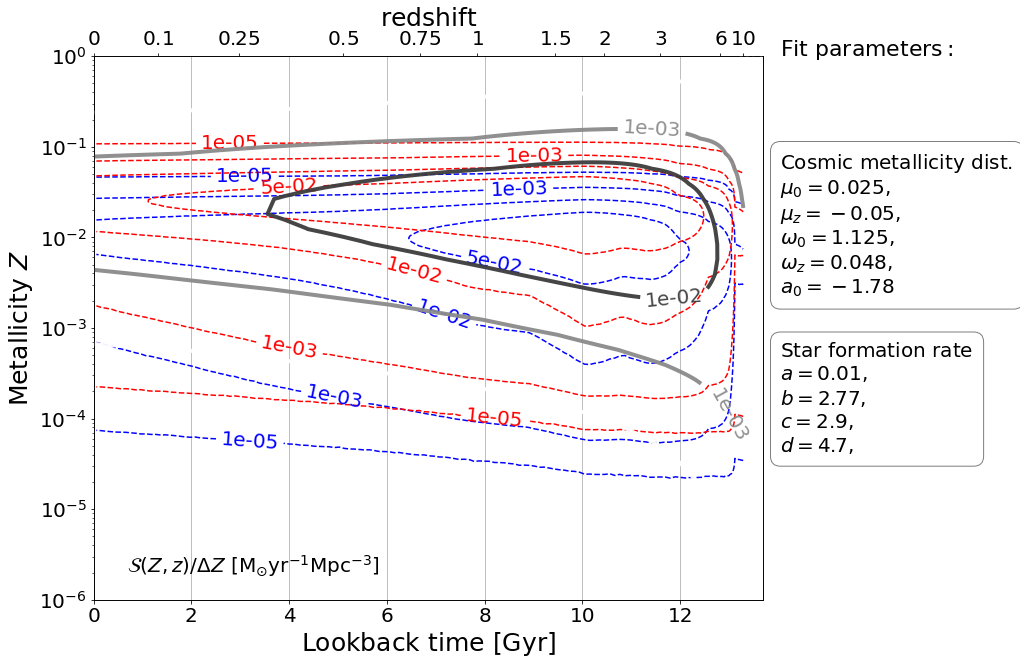

In [3]:


Z_array = FOH2ZZ(FOH_arr,solar_Z_scale='AndersGrevesse89')
print('np.shape(Z_array)', np.shape(Z_array) )

######################################
# Best fit parameters
mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(paths.data / 'best_fit_parameters.txt',unpack=True)

fid_dpdZ_parameters = [mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best]
fid_sfr_parameters  = [sf_a_best, sf_b_best, sf_c_best, sf_d_best]


print(fid_dpdZ_parameters, fid_sfr_parameters)

######################################
# SFRD comparison plot
######################################
def Single_panel(obs_SFRD = [], mu_0=0.025, mu_z=-0.49,alpha = -1.77, sigma_0=1.129, sigma_z =0.048,
                    a=0.017, b=1.481, c=4.452,  d=5.913,
                    min_logZ  = -12.0, max_logZ  =0.0, step_logZ = 0.01,
                    tmin = 0.0, tmax = 13.7, add_TNG = True, add_Chruslinska = True,
                   plot_dPdZcontours = True, neijssel_fit = True,
                   FITkleur="crest", dPdZ_text = '', SFR_text = ''):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    fig, ax = plt.subplots(figsize = (12,10))
    ax.set_yscale('log')


    ######################################
    
    fit_values_string = r'$\mathrm{Cosmic \ metallicity \ dist.}$'+'\n'+\
                    r'$\mu_0=%s,$'%(np.round(mu_0,3)) +'\n'+\
                    r'$\mu_z=%s,$'%(np.round(mu_z,3)) +'\n'+\
                    r'$\omega_0=%s,$'%(np.round(sigma_0,3)) +'\n'\
                    r'$\omega_z=%s,$'%(np.round(sigma_z,3)) +'\n'\
                    r'$a_0=%s$'%(np.round(alpha,3))

    SFR_fit_string = r'$\mathrm{Star \ formation \ rate}$'+'\n'+\
                     '$a=%s,$'%(np.round(a,3)) +'\n'+\
                     '$b=%s,$'%(np.round(b,3)) +'\n'+\
                     '$c=%s,$'%(np.round(c,3)) +'\n'\
                     '$d=%s,$'%(np.round(d,3))


    ##############################################################################
    # Load TNG data (either original or interpolated)
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins         = f["MetalBins"][:]
            Obs_Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr            = f["Sfr"][:]

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        Obs_cosmic_SFR = Obs_cosmic_SFR.value
        Obs_cosmic_SFR = Obs_cosmic_SFR.T

        ##########################################
        # "observed" TNG metallicities that we use for our calculations
        ##########################################
        Obs_center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
        log_obs_metallicities = np.log10(MetalBins)
        step_obs_logZ         = np.diff(log_obs_metallicities)[0]
        
        print('step_obs_logZ',step_obs_logZ)
        print('np.amax(Obs_cosmic_SFR/dlogZ)', np.amax(Obs_cosmic_SFR/step_obs_logZ))

        
    else:
        print('Using interpolated TNG')
        Obs_Lookbacktimes = obs_lookback
        Obs_center_Zbin   = obs_metal
        Obs_cosmic_SFR    = obs_SFRD
        
    # Convert observed lookback times to observed redshifts (lookback times are decreasing, so also obs_redshift is decreasing)
    Obs_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Obs_Lookbacktimes[:-1]] 
    Obs_redshifts.insert(len(Obs_redshifts),0) # put redshift zero at the end 
    Obs_redshifts = np.array(Obs_redshifts)
    
    ##################################################################################
    ##                                                                              ##
    ##                          Top panel: SFRD                                     ##
    ##                                                                              ##
    ##################################################################################
    # The new Z-dep SFRD and Neijssel + 2019 can both be plotted at an arbitrarily 
    # high resolution in both redshift and metallicity. We'll use the following:
    print('len(Obs_center_Zbin', len(Obs_center_Zbin) )
#     log_tofit_TNG_metals = np.log10(tofit_TNG_metals)
    high_res_metals    = Obs_center_Zbin#np.logspace(min(log_tofit_TNG_metals), max(log_tofit_TNG_metals), 50)#tofit_TNG_metals#
    high_res_redshifts = np.arange(0, 10.1, 0.05)
    #Convert redshift to lookback time
    high_res_t         = cosmo.lookback_time(high_res_redshifts)

    # PLot the following contours for both models:
#     levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,5e-2,1e-1]
    levels=[1e-5,1e-3, 0.01,0.05]
     
    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_dPdZcontours:
        #####################################
        # Get data for your model 
        #####################################
        # Get dPdZ 
        dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      sigma_0=sigma_0, sigma_z =sigma_z, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals = high_res_metals, redsh = high_res_redshifts)
        # Get the SFR
        sfr        = Z_SFRD.Madau_Dickinson2014(redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
        print('min(np.log(metallicities))',min(np.log(metallicities)),
              'max(np.log(metallicities))',max(np.log(metallicities)), 'step_logZ',step_logZ)
        # Combine it into a SFRD
        model_SFRD = (sfr*(dPdlogZ).T ).value 
        print('maximum SFRD', np.amax(model_SFRD))

        #####################################
        # Plot the contours of your Z-dep SFRD
        #####################################
        model_cmap = sns.color_palette(FITkleur, as_cmap=True)
        
        cs = ax.contour(high_res_t, high_res_metals, model_SFRD, levels, 
                        linewidths=4, cmap=model_cmap,locator=ticker.LogLocator(), alpha = 0.95, zorder=20)
        ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')

        ####################################
        #print all fit values on side of plot
        ####################################
        ax.text(0.92, 0.88, '$\mathrm{Fit \ parameters:}$',  fontsize=22, transform=plt.gcf().transFigure)
        # dPdZ
        ax.text(0.92, 0.55, fit_values_string, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
        # SFR
        ax.text(0.92, 0.33, SFR_fit_string, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
    
    ##############################################################################
    #  Contours of TNG SFRD
    ##############################################################################
    if add_TNG:           
        ######################################
        # now actually plot it
        tng_color = sns.color_palette("magma", as_cmap=True, n_colors = 7) # construct smooth cmap from one colour
#         TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin, Obs_cosmic_SFR/step_obs_logZ, 
#                             rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-9,vmax=1e-1), 
#                             cmap=tng_color, alpha=0.95 ) 
        TNG = ax.contourf(Obs_Lookbacktimes, Obs_center_Zbin, Obs_cosmic_SFR/step_obs_logZ, 
                          levels, cmap=tng_color, alpha = 0.95,locator=ticker.LogLocator(),  )
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$") 
    
    
    ##############################################################################
    if add_Chruslinska:
    ##############################################################################
    #read low Z data
        low_Z_file = '204'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'
        lowZ_image, redshift, delt = get_plot_data(Martyna_data_dir + low_Z_file, zmin=0.,zmax=10)

        #read high Z data
        high_Z_file = '302'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'
        highZ_image, redshift, delt = get_plot_data( Martyna_data_dir + high_Z_file, zmin=0.,zmax=10)
        
        #Convert redshift to lookback time
        lookback_times         = cosmo.lookback_time(redshift)

        #Plot contours
        CS_lowZ=ax.contour(lookback_times, Z_array, lowZ_image.T,levels=levels,
                      colors=('b',),linestyles=('--',),linewidths=(1.5,))
        ax.clabel(CS_lowZ, inline=True, fontsize=20, fmt='%.0e')

        CS_highZ=ax.contour(lookback_times,Z_array, highZ_image.T,levels=levels,
                            colors = 'r',linestyles=('--',),linewidths=(1.5,))
        ax.clabel(CS_highZ, inline=True, fontsize=20, fmt='%.0e')
       
    ##############################################################################
    # Neijssel 2019
    ##############################################################################
    if neijssel_fit:
        #####################################
        # Get the data for Z-dep SFRD
        #####################################
        # Get dPdZ   #         neijssel_metals = np.logspace(-5., -0.5, 50)
        neijssel_dPdlogZ, neijssel_redshifts, neijssel_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(mu_0=0.035, mu_z=-0.23, alpha = 0, sigma_0=0.39, sigma_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=high_res_metals, redsh = high_res_redshifts)
        # Get the SFR Neijssel et al 2019:
        neijssel_sfr = Z_SFRD.Madau_Dickinson2014(neijssel_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        Neijssel_SFRDzZ = (neijssel_sfr*neijssel_dPdlogZ.T).value

        greys = cm.get_cmap('Greys')
        greys = greys(np.linspace(0.2,1,10)) # Don't start the cmap in white
        cs_N = ax.contour(high_res_t, high_res_metals, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                          cmap=ListedColormap(greys),locator=ticker.LogLocator())
        
    ##############################################################################
    # Plotvalues for top panel
    ######################################
    ax.text(0.05, 0.05, r"$ \mathcal{S}(Z,z)/\Delta Z \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", transform=ax.transAxes)
    ax.xaxis.grid(5) # vertical lines
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
    ax.set_ylabel('$\mathrm{Metallicity} \ Z$', fontsize = 25)
    
    ax.set_yticks(10.**np.arange(-7., 1., 1))
    
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-6, 1)
    
    
    ##############################################################################
#     print('saving here', paths.figures / 'SFRD_FIT_evaluation_compare.pdf')
#     fig.savefig(paths.figures / 'SFRD_FIT_evaluation_compare.pdf',  bbox_inches='tight', dpi=300)
    
    # plt.show()

#################################################################################################
#                                                                                               #
#       Call plot                                                                               #   
#                                                                                               #
#################################################################################################
Single_panel(mu_0=0.025, mu_z=-0.05, sigma_0=1.125, sigma_z =0.048, alpha = -1.78,
                    a=0.01, b=2.77, c=2.9,  d=4.7,
                    min_logZ  = -12.0, max_logZ  =0.0, step_logZ = 0.01,
                    add_Chruslinska = True, neijssel_fit = False,
                    add_TNG = False, plot_dPdZcontours = True, 
                   FITkleur="Greys", dPdZ_text = '', SFR_text = '')




# Martyna's plot functions

From her 2021 paper: https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.4994C/abstract

online data available: https://ftp.science.ru.nl/astro/mchruslinska/Chruslinska_et_al_2021/



$\mathdefault{5}$
$\mathdefault{5}$ AndersGrevesse89
$\mathdefault{6}$
$\mathdefault{6}$ AndersGrevesse89
$\mathdefault{7}$
$\mathdefault{7}$ AndersGrevesse89
$\mathdefault{8}$
$\mathdefault{8}$ AndersGrevesse89
$\mathdefault{9}$
$\mathdefault{9}$ AndersGrevesse89
$\mathdefault{10}$
$\mathdefault{10}$ AndersGrevesse89


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator


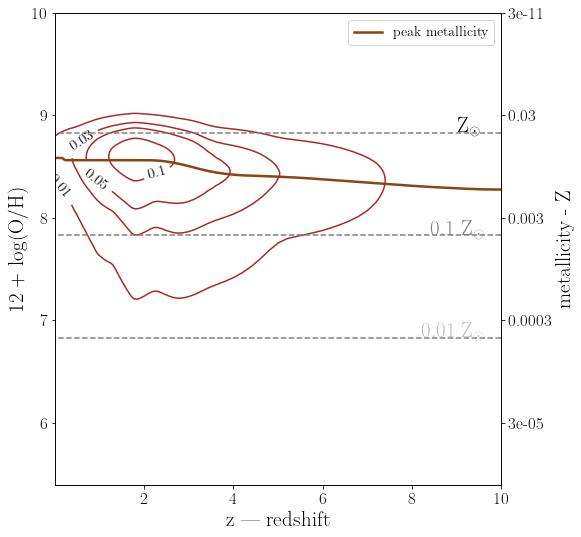

In [3]:
''' 
# online material accompanying the paper: Chruslinska, M. et al., MNRAS, 2021 (DOI: 10.1093/mnras/stz2057)
# this python script allows to visualize the data (plot the SFRD(Z,z) distribution and CDF at a given redshift)
# usage: python plot_SFRD_Z_z.py
# adjust the data input file name (input_file); see example use at the bottom
# need 'Time_redshift_deltaT.dat' and input file with the data for a chosen variation (any of the '*FOH_z_dM.dat')
'''

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import matplotlib.colors as colors


Martyna_data_dir = '/Users/lieke/surfdrive/Documents/SFRD_fit/src/data/SFRD_Z_z_data/'

labelsize=21
ticklabsize=17

def solar_metallicity_scales():
    Asplund09=[0.0134,8.69]
    AndersGrevesse89=[0.017,8.83]
    GrevesseSauval98=[0.0201,8.93]
    Villante14=[0.019,8.85]
    scale_ref=np.array(['Asplund09','AndersGrevesse89','GrevesseSauval98','Villante14'])
    Z_FOH_solar=np.array([Asplund09,AndersGrevesse89,GrevesseSauval98,Villante14])
    return scale_ref, Z_FOH_solar


##########################
def FOH2ZZ(foh,solar_Z_scale='AndersGrevesse89'):
    '''convert from 12+log[O/H] to ZZ'''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]    
    logZ = np.log10(Zsun) + foh - FOHsun
    ZZ=10**logZ
    return ZZ
#########################

def ZZ2FOH(zz,solar_Z_scale='AndersGrevesse89'):
    '''convert from ZZ to 12+log[O/H] '''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]
    foh = np.log10(zz)-np.log10(Zsun)+FOHsun
    return foh

def smooth(d, c=2):
    if c == 0:
        return d
    x = np.zeros(len(d))
    x[0] = (d[1]+d[0])/2
    x[-1] = (d[-1]+d[-2])/2
    x[1:-1] = (2*d[1:-1]+d[:-2]+d[2:])/4
    return smooth(x, c=c-1)

#(array) oxygen to hydrogen abundance ratio ( FOH == 12 + log(O/H) )
# as used in the calculations - do not change
FOH_min, FOH_max = 5.3, 9.7
FOH_arr = np.linspace( FOH_min,FOH_max, 200)
dFOH=FOH_arr[1]-FOH_arr[0]

def get_plot_data(input_file,zmin=0.,zmax=4):

    #read time, redshift and timestep as used in the calculations
    #starts at the highest redshift (z=z_start=10) and goes to z=0
    time, redshift_global, delt = np.loadtxt(Martyna_data_dir+'Time_redshift_deltaT.dat',unpack=True) 
    #reading mass per unit (comoving) volume formed in each z (row) - FOH (column) bin
    data=np.loadtxt(input_file)
    image_data=np.array( [data[ii]/(1e6*delt[ii]) for ii in range(len(delt))] )#fill the array with SFRD(FOH,z)

    redshift=redshift_global
    #select the interesting redshift range
    if( zmax!=10 or zmin!=0 ):
        idx= np.where(np.abs(np.array(redshift)-zmax)==np.abs(np.array(redshift)-zmax).min())[0][0] 
        idx0= np.where(np.abs(np.array(redshift)-zmin)==np.abs(np.array(redshift)-zmin).min())[0][0] 
        image_data = image_data[idx:idx0]
        redshift=redshift_global[idx:idx0]
        delt=delt[idx:idx0]

    image_data/=dFOH
    return image_data, redshift, delt

def plot_data_single_panel(input_file, zmin=0.,zmax=10,solar_Z_scale='AndersGrevesse89'):

    #read data
    image,redshift,delt = get_plot_data(input_file,zmin,zmax)

    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]
    FOHymin,FOHymax=5.39,10.
  
    # Draw the figure
    fig1=plt.figure(figsize=(8.5,6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=3)
    ax11 = ax1.twinx()

    #plotting
    vmin=3e-5
    vmax=0.22
#     idx_peak_SFRH = np.where( np.abs(np.array(redshift)-1.8)==np.min(np.abs(np.array(redshift)-1.8)) )[0][0]
    c='saddlebrown'
    image1 = ndimage.gaussian_filter(image,1,0)
    
    # Background color
#     pcm=ax1.pcolormesh(redshift, FOH_arr, np.transpose(image1),norm=colors.LogNorm(vmin=vmin, vmax=vmax ))#,cmap='OrRd' )

    # Contour
    levels=[0.01,0.03,0.05,0.1]
    CS=ax1.contour(redshift,FOH_arr, np.transpose(image1),levels=levels,colors=('brown',),linestyles=('-',),linewidths=(1.5,))
    ax1.clabel(CS, fmt = '%g', colors ='k', fontsize=15) #contour line labels
    
    # Plot maximum SFR at every redshift
    SFRD_atz_Z = np.array([image1[:][ii] for ii in range(len(image1[:,0]))])
    maxima = np.array([SFRDi[2:].max() for SFRDi in SFRD_atz_Z ])
    indices=[np.where( np.abs(maxi-SFRDi[2:])==np.min(np.abs(maxi-SFRDi[2:])))[0][-1] for maxi,SFRDi in zip(maxima,SFRD_atz_Z)]
    FOHmax=np.array(FOH_arr[indices])+(FOH_arr[1]-FOH_arr[0])*0.5
    ax1.plot(redshift,smooth(np.array(FOHmax),10),lw=2.5,c=c,label='peak metallicity')

    #prepare labels for y-axes
    fig1.canvas.draw()
    labels = [item.get_text() for item in ax1.get_yticklabels()]
    labels2=[]
    for l in labels[:]:
            l.replace(r'$\mathdefault{', '')
            l.replace(r'}$', '')
            print(l)
            if l=='': labels2.append('')
            else:
                print(l,solar_Z_scale )
                labels2.append( str('%.1g'%(FOH2ZZ(float(l[-3]),solar_Z_scale))) )
    labels1=[]
    labels1.append('')
    labels1+=labels[1:]
    ax1.set_yticklabels(labels1)
    ax11.set_yticklabels(labels2)

    #add legend
    lgnd = ax1.legend( loc='upper right', prop={'size':int(14)},\
            fancybox=True,numpoints=1,scatterpoints = 1)#,frameon=False)
    frame = lgnd.get_frame()
    frame.set_alpha(0.85)

    #adjust size
    w,h=fig1.get_size_inches()
    fig1.set_size_inches(w,h+2.2, forward=True)
    ttop,lleft,rright,bbottom=0.88,0.12,0.85,0.08
    plt.subplots_adjust(left=lleft, bottom=bbottom, right=rright, top=ttop, wspace=0.01, hspace=0.0)

#     #add colorbar
#     cbaxes = fig1.add_axes([lleft, ttop, rright-lleft, 0.01])
# #     cb=plt.colorbar(pcm, orientation='horizontal', cax=cbaxes)
#     cb.set_label(label=r'$\rm \frac{SFRD}{\Delta z \Delta Z_{O/H}} [M_{\odot}/Mpc^{3}yr]$',\
#                 size=labelsize+2, labelpad=15)
#     cb.ax.xaxis.set_ticks_position('top')
#     cb.ax.xaxis.set_label_position('top')
#     cb.ax.tick_params(labelsize=ticklabsize)

    #add description    
    ax1.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            top=False, #top ticks off
            labelbottom=True,
            labeltop=False,
            labelleft=True,
            labelright=False,
            labelsize=ticklabsize) # labels along the bottom edge are off
    ax11.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            top=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=True,
            labelsize=ticklabsize) # labels along the bottom edge are off

    # Right y-axis: metallicity
    ax11.set_ylim([FOHymin,FOHymax])
    ax11.set_ylabel('metallicity - Z',fontsize=labelsize )
    
    # left y-axis: redshift
    ax1.set_xlabel('redshift')
    ax1.set_ylim([FOHymin,FOHymax])
    ax1.set_ylabel('12 + log(O/H)',fontsize=labelsize )
    ax1.set_xlim([min(redshift), max(redshift)])
    ax1.set_xlabel('z --- redshift', fontsize=labelsize)

    cann,cann2='gray','gray'
    ax1.plot( redshift, [FOHsun for z in redshift], ls='--', c=cann2,lw=1.5)
    ax1.annotate(r'Z$_{\odot}$', xy=(redshift[5],ZZ2FOH(Zsun,solar_Z_scale)+0.0005),\
     xycoords='data',fontsize=labelsize, fontweight='bold',color='k')
    ax1.plot( redshift, [ZZ2FOH(0.1*Zsun,solar_Z_scale) for z in redshift], ls='--', c=cann2,lw=1.5)
    ax1.annotate(r'0.1 Z$_{\odot}$', xy=(redshift[8],ZZ2FOH(0.1*Zsun,solar_Z_scale)+0.0005),\
     xycoords='data',fontsize=labelsize, fontweight='bold',color=cann)
    cann,cann2='silver','gray'
    ax1.plot( redshift, [ZZ2FOH(0.01*Zsun,solar_Z_scale) for z in redshift], ls='--', c=cann2,lw=1.5)
    ax1.annotate(r'0.01 Z$_{\odot}$', xy=(redshift[9],ZZ2FOH(0.01*Zsun,solar_Z_scale)+0.00005),\
     xycoords='data',fontsize=labelsize, fontweight='bold',color=cann)

    plt.show()

def prepare_CDF(SFRD_data):

    #NORMALIZE the input data
    mtot_z = [np.sum(SFRD_data[:][ii]) for ii in range(SFRD_data.shape[0])]
    SFRD_normed = np.array([ [(SFRD_data[ii][j])/mtot_z[ii] for\
                     j in range(SFRD_data.shape[1])] for ii in range(SFRD_data.shape[0])]) 
    #CALCULATE the cumulative sum of the data
    Z_cumsum = np.array([ [np.sum(SFRD_normed[ii][:j]) for j in range(SFRD_data.shape[1])]\
                             for ii in range(SFRD_data.shape[0])])
    Z_cumsum=np.transpose(Z_cumsum)
    return Z_cumsum

def plot_CDF(input_file, zzi=[0], color='g',label='' ):

    image,redshift,delt = get_plot_data(input_file,zmin=0,zmax=10)
    Z_cumsum=prepare_CDF(image)
    redshift=np.array(redshift)

    fig1=plt.figure(1)
    ax1 = fig1.add_subplot(111)
    ax1.tick_params(axis='x', which='major', labelsize=ticklabsize)
    ax1.tick_params(axis='y', which='major', labelsize=ticklabsize)
    ax1.set_ylabel('fraction of SFRD at Z$_{O/H}<x$',fontsize=labelsize)
    ax1.tick_params(axis='x', which='major', labelsize=ticklabsize)
    ax1.tick_params(axis='y', which='major', labelsize=ticklabsize)
    ax1.set_ylim([0.,1.05])
    ax1.set_xlim([6.,10])
    ax1.set_xlabel('12+log(O/H)',fontsize=labelsize)

    lw=2
    alpha=1
    colors = plt.cm.jet(np.linspace(0,1,len(zzi)))
    for z,c in zip(zzi,colors):
        iz=np.where( np.abs(redshift-z)==np.min( np.abs(redshift-z) ) )[0][0]
        frac_Z=Z_cumsum[:,iz] #CDF at z=zzi
        if(len(zzi)==1):
                ax1.plot(FOH_arr, frac_Z,c=color,ls='-',lw=lw,label=label+'; z='+str(z),alpha=alpha)
        else:
                ax1.plot(FOH_arr, frac_Z,c=c,ls='-',lw=lw,label='z='+str(z),alpha=alpha)
    return Z_cumsum

''' Example use: '''
''' plot the SFRD(Z,z) distribution (as e.g. in Fig. 7 from the paper) '''
# solar metallicity is shown in the figure to guide the eye; the conversion can be changed
# (see function solar_metallicity_scales() and keyword solar_Z_scale below)
default_file = '206f14SBBiC_FMR270_FOH_z_dM.dat' 

low_Z_file = '204'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'

high_Z_file = '302'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'


plot_data_single_panel(Martyna_data_dir + low_Z_file, 
                       zmin=0., zmax=10, solar_Z_scale='AndersGrevesse89')




$\mathdefault{5}$
$\mathdefault{5}$ AndersGrevesse89
$\mathdefault{6}$
$\mathdefault{6}$ AndersGrevesse89
$\mathdefault{7}$
$\mathdefault{7}$ AndersGrevesse89
$\mathdefault{8}$
$\mathdefault{8}$ AndersGrevesse89
$\mathdefault{9}$
$\mathdefault{9}$ AndersGrevesse89
$\mathdefault{10}$
$\mathdefault{10}$ AndersGrevesse89


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator


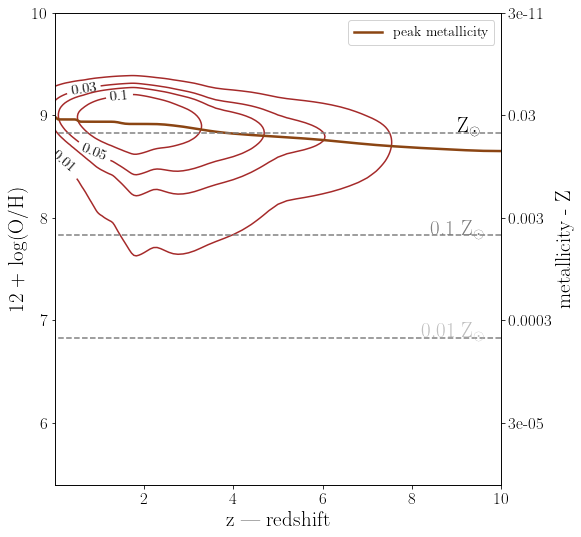

In [22]:
high_Z_file = '302'+ 'f14SB'+'Boco'+ '_FMR270'+ '_FOH_z_dM.dat'

plot_data_single_panel(Martyna_data_dir + high_Z_file, 
                       zmin=0., zmax=10, solar_Z_scale='AndersGrevesse89')



In [6]:

##########################
#(array) oxygen to hydrogen abundance ratio ( FOH == 12 + log(O/H) )
# as used in the calculations - do not change
FOH_min, FOH_max = 5.3, 9.7
FOH_arr = np.linspace( FOH_min,FOH_max, 200)
dFOH=FOH_arr[1]-FOH_arr[0]

##########################
# Convert log(O/H) to Z metallicity
def FOH2ZZ(foh,solar_Z_scale='AndersGrevesse89'):
    '''convert from 12+log[O/H] to ZZ'''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]    
    logZ = np.log10(Zsun) + foh - FOHsun
    ZZ=10**logZ
    return ZZ

Z_array = FOH2ZZ(FOH_arr,solar_Z_scale='AndersGrevesse89')
print('np.shape(Z_array)', np.shape(Z_array) )



np.shape(Z_array) (200,)


In [7]:
# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

shape of SFR(z,Z) (150, 200)
shape of redshifts (150,)
shape of dt? (150,)
shape of metallicities (200,)


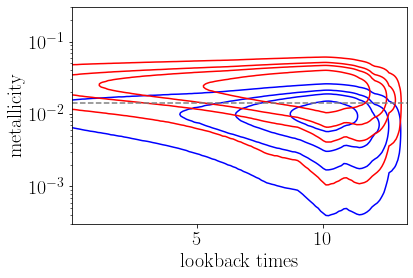

In [9]:
##########################
#read high Z data
highZ_image, redshift, delt = get_plot_data( Martyna_data_dir + high_Z_file, zmin=0.,zmax=10)

#read low Z data
lowZ_image, redshift, delt = get_plot_data(Martyna_data_dir + low_Z_file, zmin=0.,zmax=10)


#########################
print('shape of SFR(z,Z)', np.shape(highZ_image) )
print('shape of redshifts', np.shape(redshift) )
print('shape of dt?', np.shape(delt) )
print('shape of metallicities', np.shape(FOH_arr))

#Convert redshift to lookback time
lookback_times         = cosmo.lookback_time(redshift)

    
#########################
fig, ax = plt.subplots()

# Contour
levels=[0.01,0.03,0.05,0.1]
CS=ax.contour(lookback_times,Z_array, np.transpose(lowZ_image),levels=levels,
              colors=('b',),linestyles=('-',),linewidths=(1.5,))


CS=ax.contour(lookback_times,Z_array, np.transpose(highZ_image),levels=levels,
              colors=('r',),linestyles=('-',),linewidths=(1.5,))

ax.axhline(0.014, ls = '--', c = 'grey')
ax.set_yscale('log')
ax.set_ylim(3e-4, 0.3)
ax.set_xlabel('lookback times')
ax.set_ylabel('metallicity')
plt.show()

In [ ]:
# #         Let's not use ALL metallicities in the TNG.. (they go waay too low!)
#         low_bound_Z_ind = np.where(Obs_center_Zbin > 1e-5)[0]# index of Obs_center_Zbin, where Z > 1e-5
#         bound_Z_ind = np.where(np.logical_and(Obs_center_Zbin > 1e-5, Obs_center_Zbin < 50*0.014))[0]# index of Obs_center_Zbin, where Z < 50 Zsun
#         tofit_TNG_metals = Obs_center_Zbin[bound_Z_ind]  